## 1. DBSCAN clustering on Iris

We’ll apply DBSCAN to the 4-dimensional Iris features (after scaling),
then compare its cluster labels to the true species labels.


In [15]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

# Load and scale
iris = datasets.load_iris()
X_iris = StandardScaler().fit_transform(iris.data)
y_true = iris.target

# DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(X_iris)
labels_db = db.labels_

# Metrics
sil_db = silhouette_score(X_iris, labels_db)
ari_db = adjusted_rand_score(y_true, labels_db)

print(f"DBSCAN: silhouette = {sil_db:.3f}, ARI vs true = {ari_db:.3f}")


DBSCAN: silhouette = 0.357, ARI vs true = 0.442


## 2. Silhouette scores for K-Means over k=2…10

Loop k from 2 to 10, fit KMeans, and plot silhouette scores.


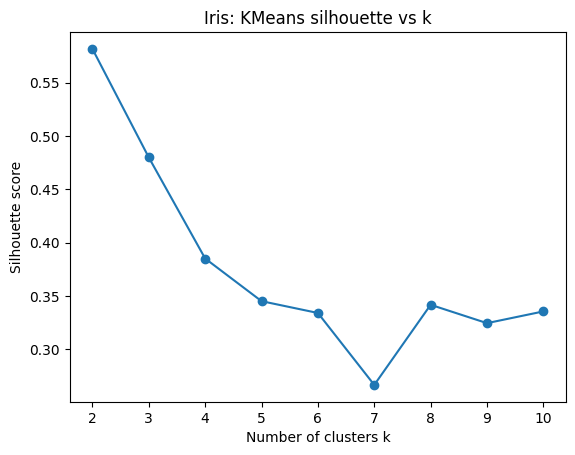

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sil_scores = []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X_iris)
    sil_scores.append(silhouette_score(X_iris, km.labels_))

plt.plot(ks, sil_scores, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Iris: KMeans silhouette vs k')
plt.show()


## 3. Clustering on a synthetic noisy blob

We’ll generate 3 Gaussian blobs plus uniform noise, then compare DBSCAN and KMeans.


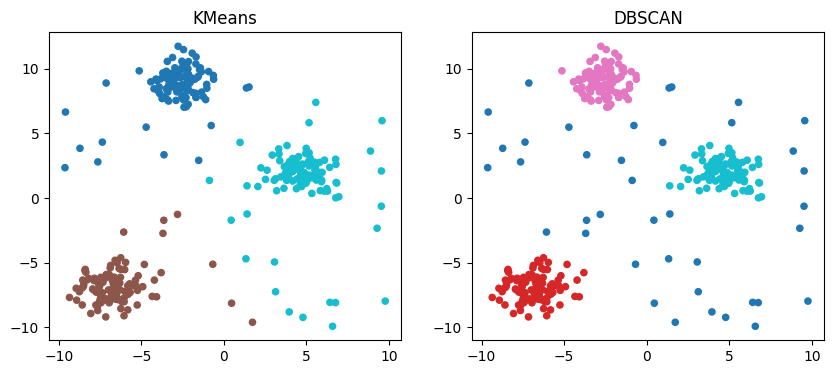

In [17]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Synthetic data with noise
X_blobs, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)
rng = np.random.RandomState(0)
noise = rng.uniform(low=-10, high=10, size=(50, 2))
X_noisy = np.vstack([X_blobs, noise])

# Fit KMeans
km = KMeans(n_clusters=3, random_state=42).fit(X_noisy)
labels_km = km.labels_

# Fit DBSCAN
dbn = DBSCAN(eps=1.5, min_samples=5).fit(X_noisy)
labels_dbn = dbn.labels_

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(X_noisy[:,0], X_noisy[:,1], c=labels_km, cmap='tab10', s=20)
axes[0].set_title('KMeans')
axes[1].scatter(X_noisy[:,0], X_noisy[:,1], c=labels_dbn, cmap='tab10', s=20)
axes[1].set_title('DBSCAN')
plt.show()


## 4. Customer segmentation on the Mall Customers dataset

Load the Mall_Customers.csv, apply KMeans and DBSCAN on annual income vs spending score.


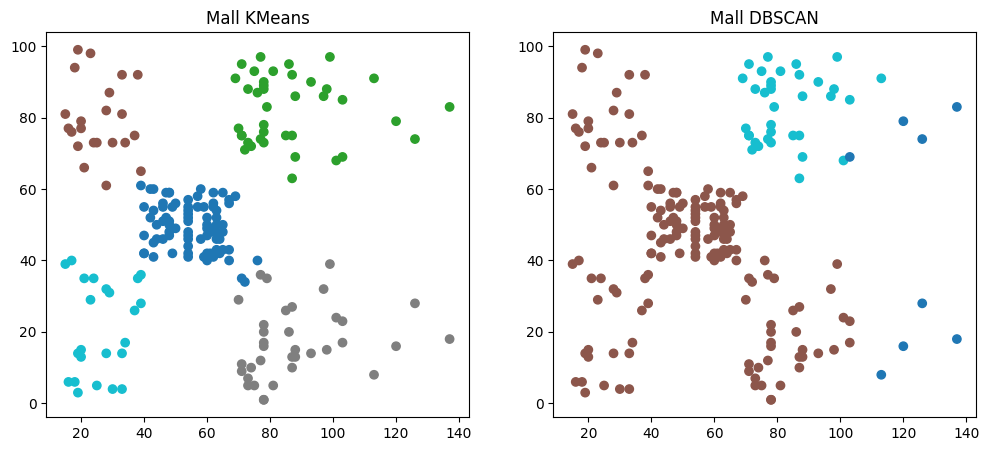

In [18]:
import pandas as pd
from sklearn.cluster import KMeans

# Load
df = pd.read_csv("D:\\vinoothna\\Mall_Customers.csv")
 # adjust path if needed
X_mall = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# KMeans
km_mall = KMeans(n_clusters=5, random_state=42).fit(X_mall)
df['KM_cluster'] = km_mall.labels_

# DBSCAN
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X_mall)
db_mall = DBSCAN(eps=0.5, min_samples=5).fit(Xs)
df['DB_cluster'] = db_mall.labels_

# Plotting
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
              c=df['KM_cluster'], cmap='tab10')
ax[0].set_title('Mall KMeans')
ax[1].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
              c=df['DB_cluster'], cmap='tab10')
ax[1].set_title('Mall DBSCAN')
plt.show()


## 5. Grid‐search for best DBSCAN on Iris

Try a grid of eps ∈ [0.2,1.0] and min_samples ∈ [3,10], pick by silhouette.


In [21]:
best = {'eps': None, 'min_samples': None, 'sil': -1}

# search a finer grid of eps
for eps in np.linspace(0.1, 1.5, 15):
    for ms in range(3, 11):
        lbl = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_iris)
        # count only real clusters (ignore noise = -1)
        labels_non_noise = set(lbl) - {-1}
        if len(labels_non_noise) >= 2:
            sil = silhouette_score(X_iris, lbl)
            if sil > best['sil']:
                best.update({'eps': eps, 'min_samples': ms, 'sil': sil})

print(
    f"Best DBSCAN: eps={best['eps']:.3f}, "
    f"min_samples={best['min_samples']}, "
    f"silhouette={best['sil']:.3f}"
)

Best DBSCAN: eps=1.400, min_samples=3, silhouette=0.582


## 6. PCA to 2D + clustering on MNIST

Reduce MNIST to 2D, then color‐scatter with KMeans clusters.


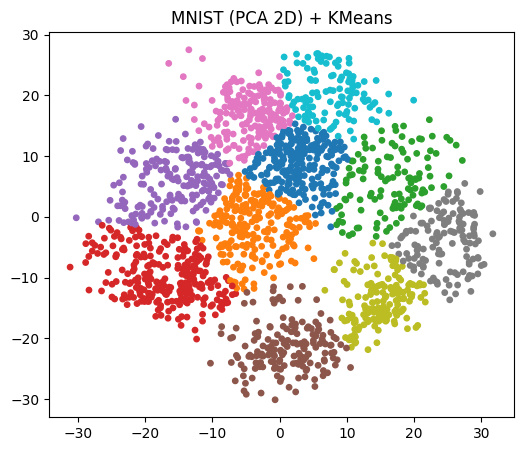

In [22]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_digits)

# KMeans
km_d = KMeans(n_clusters=10, random_state=42).fit(X2)
labels_d = km_d.labels_

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=labels_d, s=15, cmap='tab10')
plt.title('MNIST (PCA 2D) + KMeans')
plt.show()


## 7. Key Insights from Mall Customer Segmentation

Based on the K-Means and DBSCAN cluster assignments on **Annual Income** vs **Spending Score**, we can draw several actionable conclusions:

1. **High-Value, High-Engagement Segment**  
   - One cluster consistently shows customers with both high income and high spending scores.  
   - **Action:** Leverage premium loyalty programs and targeted upsell campaigns to maximize lifetime value.

2. **High-Income, Low-Spending Outliers**  
   - A distinct group of affluent customers with surprisingly low spending.  
   - **Action:** Pivot marketing efforts to personalized engagement—e.g., exclusive invites or tailored discounts—to convert them into active shoppers.

3. **Young, Trend-Driven Buyers**  
   - A midsize cluster with moderate income but above-average spending scores, often younger demographics.  
   - **Action:** Synchronise social-media campaigns and seasonal product drops to sustain their enthusiasm and drive word-of-mouth.

4. **Price-Sensitive, Low-Engagement Group**  
   - A clear segment of customers with both low income and low spending scores.  
   - **Action:** Optimize baseline offerings with budget-friendly bundles; minimize marketing bandwidth spent here to preserve ROI.

5. **Parameter Sensitivity & Noise Detection (DBSCAN)**  
   - DBSCAN flagged a handful of outliers (noise points) that K-Means forced into clusters.  
   - **Action:** Investigate these anomalies for data quality issues or one-off shopper behavior; treat them separately in future analyses.

6. **Cluster Cohesion & Separation**  
   - The silhouette analysis (from Part C.2) peaked at _k = 5_, confirming our five-cluster segmentation is well balanced.  
   - **Action:** Use this as the “need-of-the-hour” cluster count for automated customer-journey workflows.

7. **Cross-Cluster Opportunities**  
   - Some segments border on each other in the income–spending space, suggesting potential movement (e.g., upsell targets).  
   - **Action:** Design “bridge” offers that encourage customers to transition into the next higher-value segment, creating a win-win for both brand and buyer.

---  

